In [1]:
# Multiplicative scaling constants
B_b   = 1e1
b_B   = 1/B_b
G_1   = 1e9
one_G = 1/G_1
G_K   = 1e6
K_G   = 1/G_K
G_M   = 1e3
M_G   = 1/G_M
K_1   = 1e3
one_K = 1/K_1
M_1   = 1e6
one_M = 1/M_1
m_1   = 1e-3
one_m = 1/m_1
m_u   = 1e3 
u_m   = 1/m_u
u_1   = 1e-6
one_u = 1/u_1
n_1   = 1e-9
one_n = 1/n_1
n_m   = 1e-6
m_n   = 1/n_m
n_u   = 1e-3
u_n   = 1/n_u

sz1K  = 1024
sz1M  = sz1K*sz1K
sz1G  = sz1M*sz1K


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from datetime import datetime

sns.set(style="darkgrid")

# Compute statistical moments: mean, std, skewness, kurtosis
def compute_moments(series):
    values = series #.dropna()
    return {
        'count': len(values),
        'mean': values.mean(),
        'std': values.std(),
        'skew': skew(values),
        'kurtosis': kurtosis(values)
    }

# Load the log file into a list of lines
def load_log_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines if line.strip()]


In [3]:
pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yaml
import pandas as pd
from pandas import json_normalize

# Load YAML
with open("cpu_sim.yaml", "r") as f:
    data = yaml.safe_load(f)

# Flatten into a DataFrame
prmtrs_df = json_normalize(data, sep=".")
print(prmtrs_df.T)  # transpose to make it easier to read

cmp_ltnc_nS_B   = float(prmtrs_df['cmp_ltnc_nS_B'].iloc[0])
output_size_GB  = float(prmtrs_df['output_size_GB'].iloc[0])
nic_Gbps        = float(prmtrs_df['nic_Gbps'].iloc[0])
frame_sz_MB     = float(prmtrs_df['frame_sz_MB'].iloc[0])
frame_cnt       = int(prmtrs_df['frame_cnt'].iloc[0])
cmpnt_cnt       = int(prmtrs_df['cmpnt_cnt'].iloc[0])
avg_bit_rt_Gbps = float(prmtrs_df['avg_bit_rt_Gbps'].iloc[0])

                          0
cmp_ltnc_nS_B     500.00000
output_size_GB      0.00006
nic_Gbps          100.00000
frame_sz_MB         0.06000
frame_cnt        1000.00000
cmpnt_cnt           7.00000
avg_bit_rt_Gbps     0.01500


In [5]:
prmtrs_df

cmp_ltnc_nS_B  output_size_GB  nic_Gbps  frame_sz_MB  frame_cnt  cmpnt_cnt  \
0            500         0.00006       100         0.06       1000          7   

   avg_bit_rt_Gbps  
0            0.015

In [6]:
print(cmp_ltnc_nS_B,output_size_GB,nic_Gbps,frame_sz_MB,frame_cnt,cmpnt_cnt,avg_bit_rt_Gbps)

500.0 6e-05 100.0 0.06 1000 7 0.015


Empirical mean: 6.772929853165097
Empirical std: 1.29980768335369


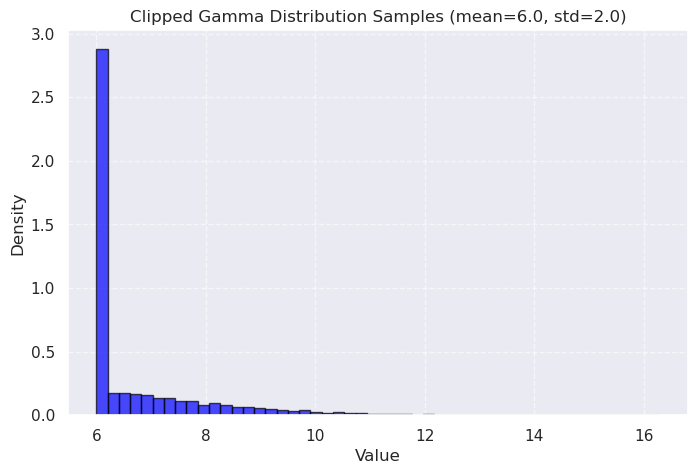

In [7]:
# Network Latency Samples
import numpy as np
import matplotlib.pyplot as plt

nl_uS = float(one_u*M_1*frame_sz_MB/(b_B*G_1*nic_Gbps))
# Target mean and std
nl_mean_uS = nl_uS
nl_std_uS = nl_uS/3

# Derive Gamma distribution parameters
nl_k = (nl_mean_uS / nl_std_uS) ** 2         # shape
nl_theta = (nl_std_uS ** 2) / nl_mean_uS     # scale

# Sample from Gamma
raw_samples = np.random.gamma(shape=nl_k, scale=nl_theta, size=1+frame_cnt*cmpnt_cnt)
# Bound samples to lower bound
nl_smpls_uS = np.clip(raw_samples, nl_mean_uS, None)

# Verification
print("Empirical mean:", np.mean(nl_smpls_uS))
print("Empirical std:",  np.std(nl_smpls_uS))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(nl_smpls_uS, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Clipped Gamma Distribution Samples (mean={nl_mean_uS}, std={nl_std_uS})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [8]:
print(nl_mean_uS, nl_std_uS, nl_k, nl_theta)

6.0 2.0 9.0 0.6666666666666666


Empirical mean: 60546.78161529553
Empirical std: 5992.0097906118335


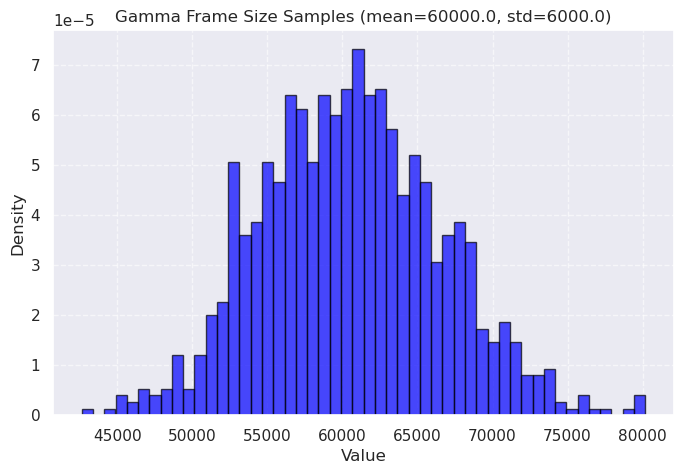

In [9]:
# Frame Size Samples
import numpy as np
import matplotlib.pyplot as plt

fs_mean_B = float(M_1*frame_sz_MB)
# Target mean and std
fs_std_B = 0.1*fs_mean_B

# Derive Gamma distribution parameters
fs_k = (fs_mean_B / fs_std_B) ** 2         # shape
fs_theta = (fs_std_B ** 2) / fs_mean_B     # scale

# Sample from Gamma
fs_smpls_B = np.random.gamma(shape=fs_k, scale=fs_theta, size=frame_cnt)

# Verification
print("Empirical mean:", np.mean(fs_smpls_B))
print("Empirical std:",  np.std(fs_smpls_B))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(fs_smpls_B, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Gamma Frame Size Samples (mean={fs_mean_B}, std={fs_std_B})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [10]:
print(fs_mean_B, fs_std_B, fs_k, fs_theta)

60000.0 6000.0 100.0 600.0


Empirical mean: 59894.32715779503
Empirical std: 6003.0895971971495


/scratch/slurm/53026789/.cache/tmp/ipykernel_1940569/2264487305.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  os_mean_B = float(G_1*prmtrs_df['output_size_GB'])


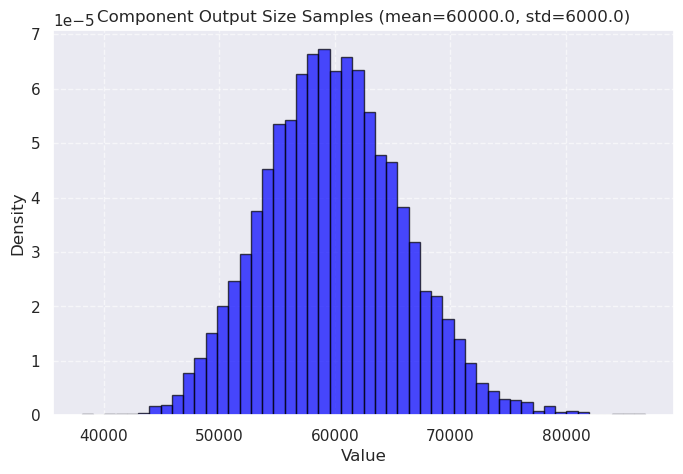

In [11]:
# Out Size Samples
import numpy as np
import matplotlib.pyplot as plt

os_mean_B = float(G_1*prmtrs_df['output_size_GB'])
# Target mean and std
os_std_B = 0.1*os_mean_B

# Derive Gamma distribution parameters
os_k = (os_mean_B / os_std_B) ** 2         # shape
os_theta = (os_std_B ** 2) / os_mean_B     # scale

# Sample from Gamma
os_smpls_B = np.random.gamma(shape=os_k, scale=os_theta, size=1+frame_cnt*cmpnt_cnt)

# Verification
print("Empirical mean:", np.mean(os_smpls_B))
print("Empirical std:",  np.std(os_smpls_B))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(os_smpls_B, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Component Output Size Samples (mean={os_mean_B}, std={os_std_B})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [12]:
print(os_mean_B, os_std_B, os_k, os_theta)

60000.0 6000.0 100.0 600.0


In [13]:
#Frames actually processed by components
prcsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "cmp_ltnc_uS": pd.Series(dtype=float),
    "ntwrk_lt_uS": pd.Series(dtype=float),
    "snt_uS":      pd.Series(dtype=float),
    "done_uS":     pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Frames that components were not ready to receive
drpmsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "lstDone_uS":  pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Data on all sent frames - component 0 is source
sentFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "snt_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float)
}) 

#set of all frame numbers from sender
all_frm_set = set(range(1, frame_cnt + 1))   # range is exclusive at the end, so add 1 for inclusive

# component 0 is the sender
clk_uS      = zeros = np.zeros(cmpnt_cnt+1, dtype=float) #Time last frame finished processing

vrbs = True

lf = open("output.txt", "w")

for f in range(0, frame_cnt):
    frm_sz0_b = B_b*fs_smpls_B[f]
    if vrbs: print(f"{clk_uS[0]} Send frame {f} Size: {frm_sz0_b:10.2f}", file=lf)
    #component zero is the sender
    row = (0,clk_uS[0],f,frm_sz0_b)
    sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)
    for c in range(1, cmpnt_cnt+1):
        #set frame size to component output Size
        frm_szc_b = B_b*os_smpls_B[f*cmpnt_cnt+c]
        clk_c = clk_uS[c-1] #temp clk = upstream senders 'done/sent' value
        if c > 1:
            frm_sz_b = B_b*os_smpls_B[f*cmpnt_cnt+c-1]
        else:
            frm_sz_b = frm_sz0_b #component 1 uses sender frame size
        # component receives with network latency
        ntwrk_lt_uS = float(one_u*frm_sz_b/(G_1*nic_Gbps)) # fix this for jitter
        clk_c += ntwrk_lt_uS #Update temp clk for net latency
        rcd_uS = clk_c #Time would recv from upstream sender
        if vrbs: print(f"{clk_c} Component {c} Recv Frame {f} Size: {frm_sz_b:10.2f}", file=lf)
        if (clk_uS[c] > clk_c): 
            if vrbs: print(f"{clk_c} Component {c} Missed Frame {f}", file=lf)
            row = (c,rcd_uS,f,frm_sz_b,clk_uS[c])
            drpmsdFrms_df = pd.concat([drpmsdFrms_df, pd.DataFrame([row], columns=drpmsdFrms_df.columns)], ignore_index=True)
            break; #If temp clk > components last 'done' time, frame is missed for this and all downstream components
        # component processes with compute latency
        cmp_ltnc_uS = float(n_u*cmp_ltnc_nS_B*frm_sz_b*b_B) # fix this for jitter
        clk_c += cmp_ltnc_uS #Update temp clk for compute latency
        clk_c += 10 #add overhead
        snt_uS = clk_c
        row = (c,snt_uS,f,frm_szc_b)
        sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)
        clk_c += 10 #add overhead
        clk_uS[c]  = clk_c #Set as last 'done' time
        if vrbs and c == cmpnt_cnt: print(f"Update sim clock to {clk_c} for component {c}", file=lf)
        if vrbs: print(f"{clk_c} Component {c} Done Frame {f} Size: {frm_sz_b:10.2f}", file=lf)
        #add prcsdFrms_df row
        row = (c,rcd_uS,f,frm_sz_b,cmp_ltnc_uS,ntwrk_lt_uS,snt_uS,clk_uS[c])
        prcsdFrms_df = pd.concat([prcsdFrms_df, pd.DataFrame([row], columns=prcsdFrms_df.columns)], ignore_index=True)
    # Sender Rate Sleep
    rtSlp_uS   = float(one_u*frm_sz0_b / (G_1*avg_bit_rt_Gbps))
    clk_uS[0] += rtSlp_uS

lf.close()   # must close manually    

Component 0 Send Delta Statistics:
count: 999.000
mean: 15.139
std: 2.082
skew: 0.346
kurtosis: 0.285


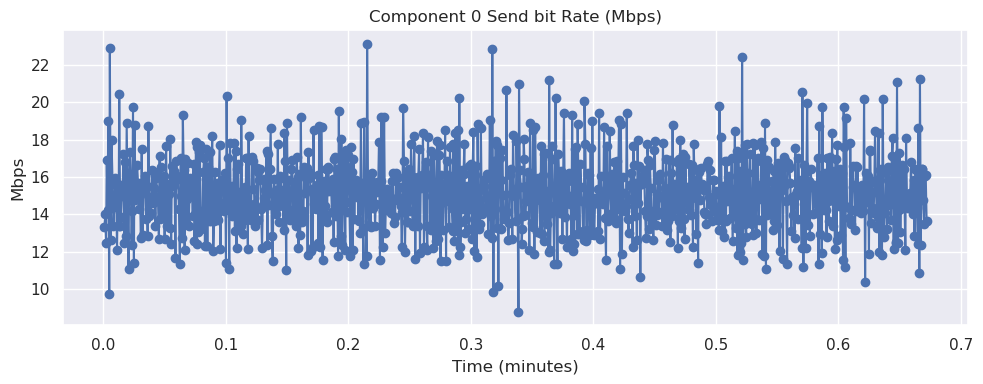

Component 1 Send Delta Statistics:
count: 999.000
mean: 14.967
std: 1.952
skew: 0.317
kurtosis: 0.222


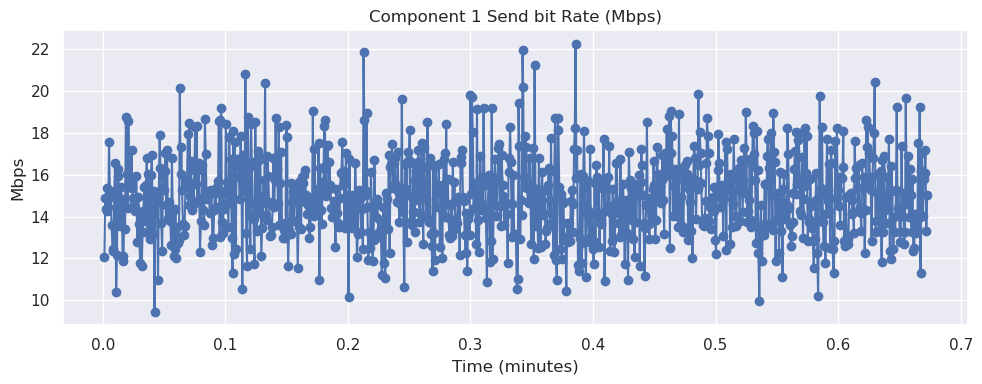

Component 2 Send Delta Statistics:
count: 989.000
mean: 14.965
std: 2.665
skew: 0.726
kurtosis: 1.189


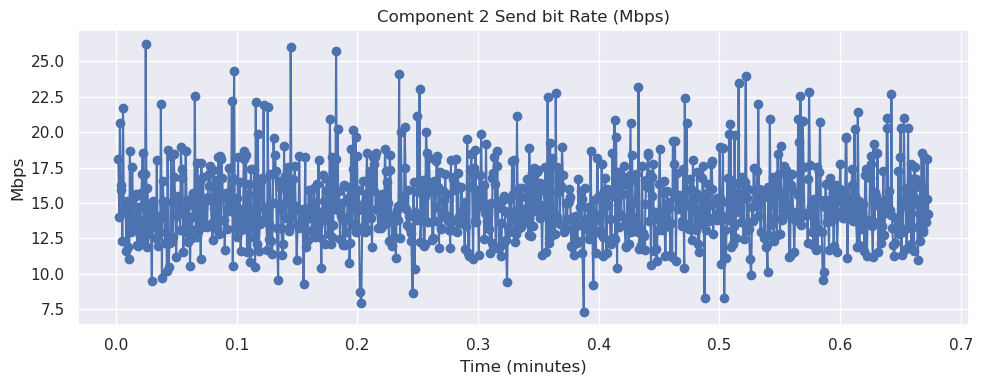

Component 3 Send Delta Statistics:
count: 942.000
mean: 14.556
std: 3.039
skew: 0.089
kurtosis: -0.108


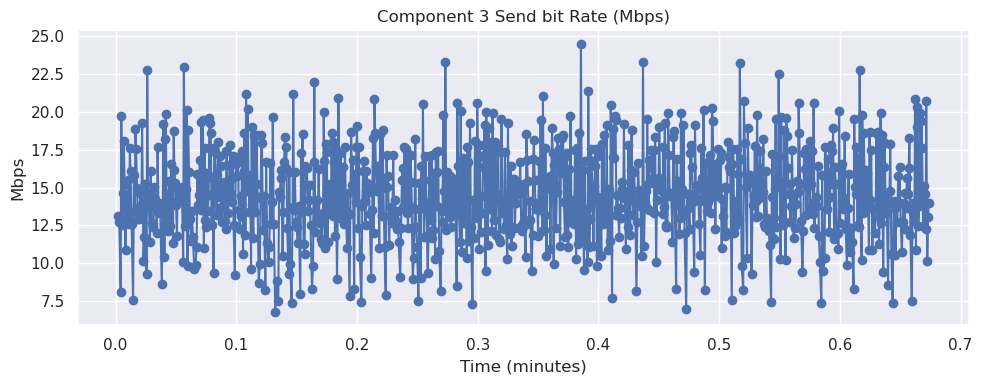

Component 4 Send Delta Statistics:
count: 898.000
mean: 14.057
std: 3.412
skew: 0.094
kurtosis: -0.197


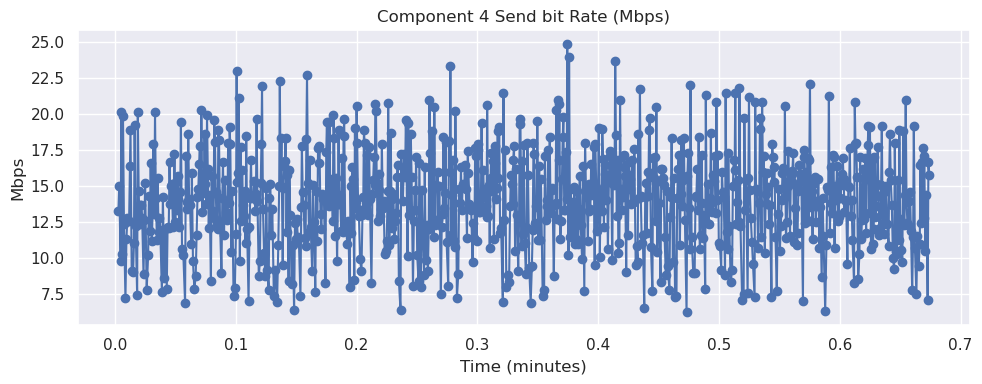

Component 5 Send Delta Statistics:
count: 851.000
mean: 13.665
std: 3.762
skew: 0.281
kurtosis: -0.321


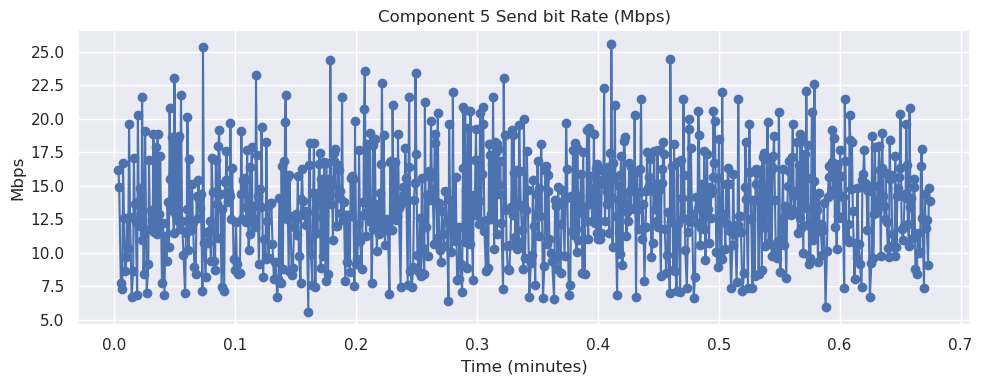

Component 6 Send Delta Statistics:
count: 805.000
mean: 12.973
std: 3.834
skew: 0.231
kurtosis: -0.458


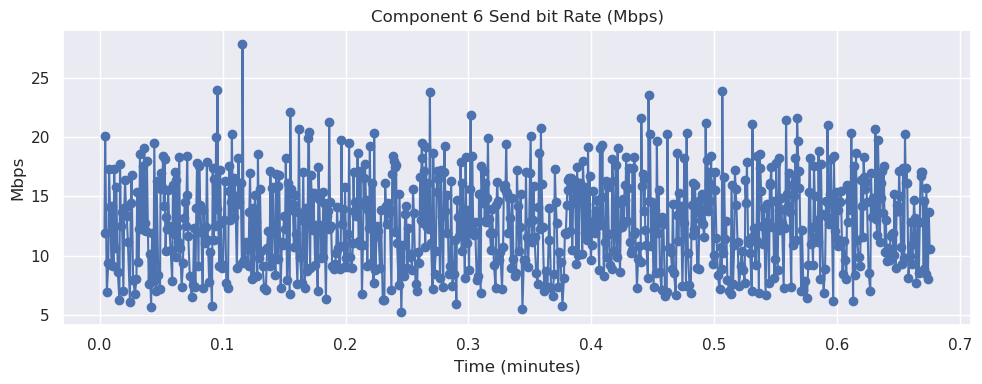

In [14]:
for i in range(0, cmpnt_cnt): #last component does not send

    sim_tm_uS = sentFrms_df.loc[sentFrms_df["component"] == i, "snt_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(sentFrms_df.loc[sentFrms_df["component"] == i, "snt_uS"][1:].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == i, "snt_uS"][:-1].reset_index(drop=True))
    szs_b = sentFrms_df.loc[sentFrms_df["component"] == i, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {i} Send Delta Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {i} Send bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Frame Rate Statistics:
count: 999.000
mean: 25.020
std: 2.505
skew: 0.409
kurtosis: 0.259


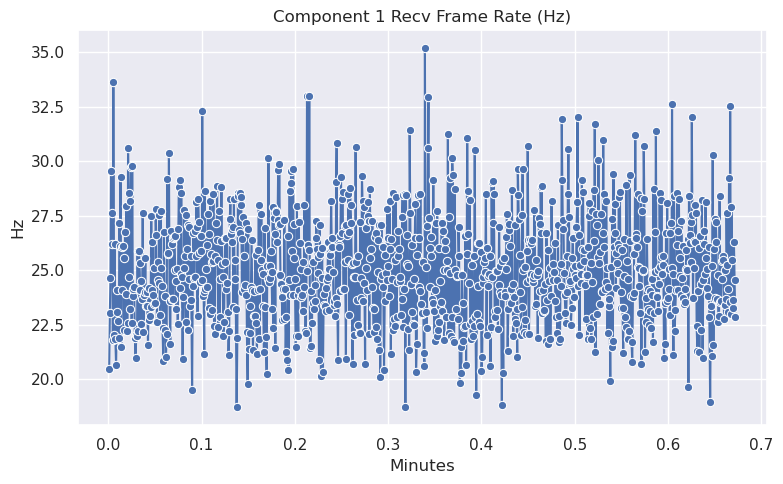

Component 2 Frame Rate Statistics:
count: 989.000
mean: 24.770
std: 2.238
skew: -1.007
kurtosis: 5.019


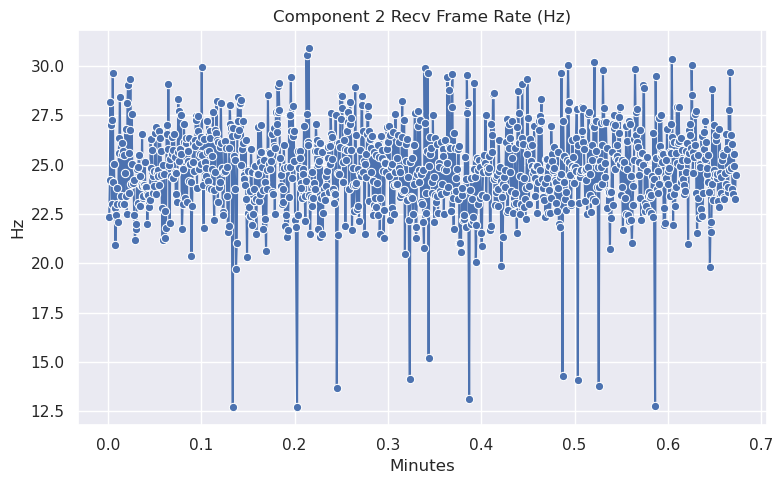

Component 3 Frame Rate Statistics:
count: 942.000
mean: 24.141
std: 3.871
skew: -0.770
kurtosis: 1.116


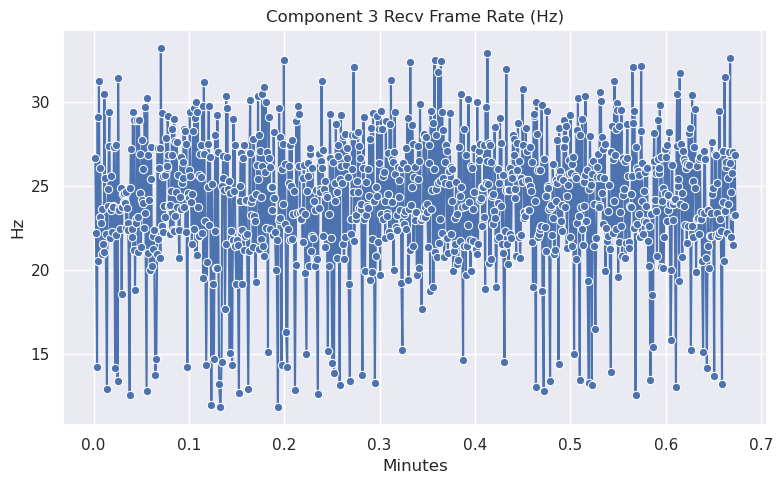

Component 4 Frame Rate Statistics:
count: 898.000
mean: 23.454
std: 4.798
skew: -0.447
kurtosis: -0.044


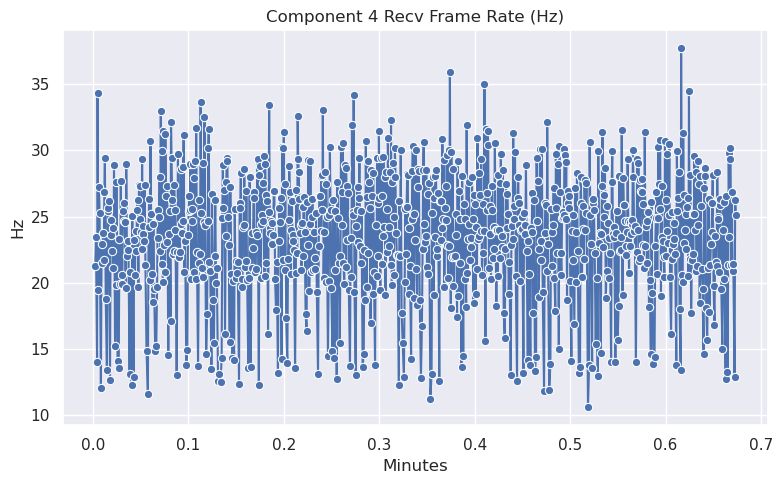

Component 5 Frame Rate Statistics:
count: 851.000
mean: 22.559
std: 5.266
skew: -0.339
kurtosis: -0.596


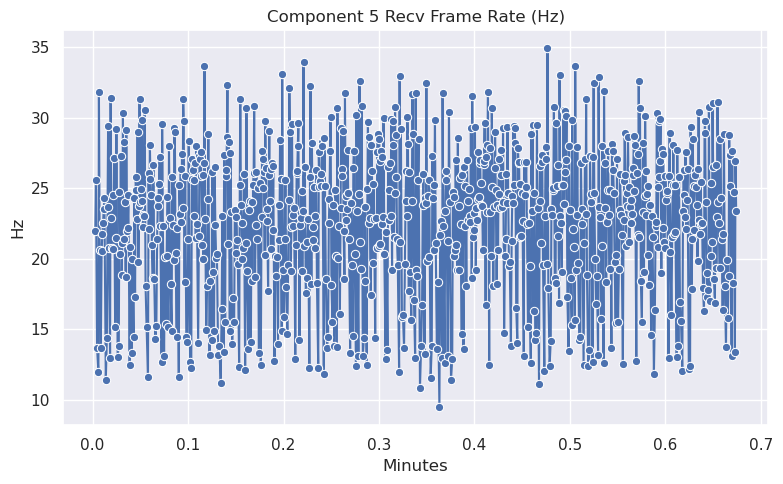

Component 6 Frame Rate Statistics:
count: 805.000
mean: 21.618
std: 5.677
skew: -0.077
kurtosis: -0.860


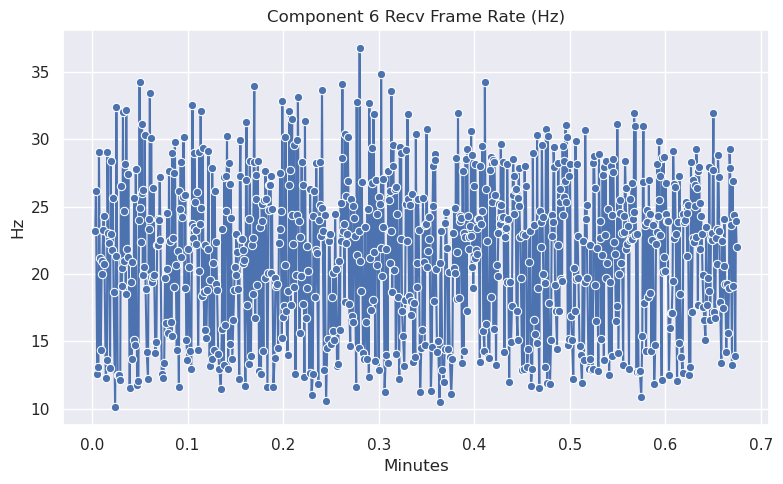

Component 7 Frame Rate Statistics:
count: 785.000
mean: 21.193
std: 5.808
skew: 0.008
kurtosis: -0.961


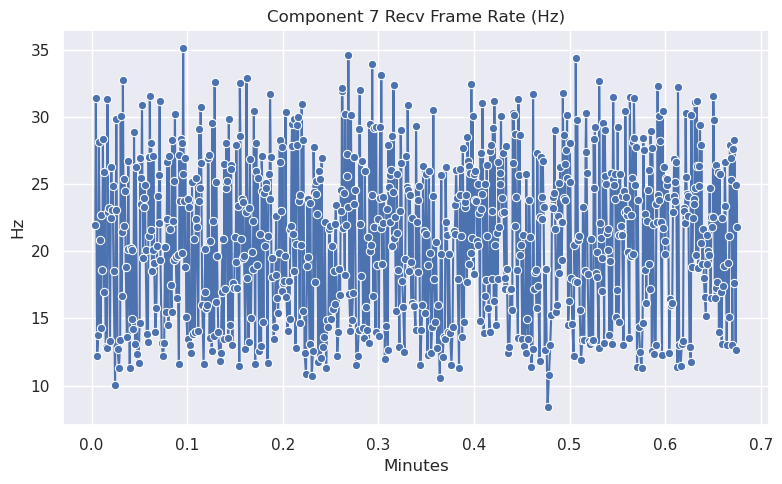

In [15]:
for i in range(1, cmpnt_cnt + 1):
    dt_S_arr           = np.diff(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"])
    frame_rates_Hz_arr = 1/dt_S_arr

    # Display statistics
    frame_rate_stats = compute_moments(frame_rates_Hz_arr)

    print(f"Component {i} Frame Rate Statistics:")
    for k, v in frame_rate_stats.items():
        print(f"{k}: {v:.3f}")

    # Plot Frame Rate
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))

    timestamps_S_arr = u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][1:]

    sns.lineplot(x=timestamps_S_arr/60.0, y=frame_rates_Hz_arr, marker="o")       # line + markers
    # —or using pure matplotlib:
    # plt.plot(x, y, marker='o', linestyle='-')

    plt.title(f"Component {i} Recv Frame Rate (Hz)")
    plt.xlabel("Minutes")
    plt.ylabel("Hz")
    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # plt.title(f"Component {index} Recv Frame Delta (uS)")
    # plt.xlabel("Minutes")
    # plt.ylabel("mS")
    # plt.tight_layout()
    # plt.show()


Component 1 Recv Delta Statistics:
count: 999.000
mean: 10.071
std: 0.999
skew: 0.175
kurtosis: -0.034


<Figure size 800x500 with 0 Axes>

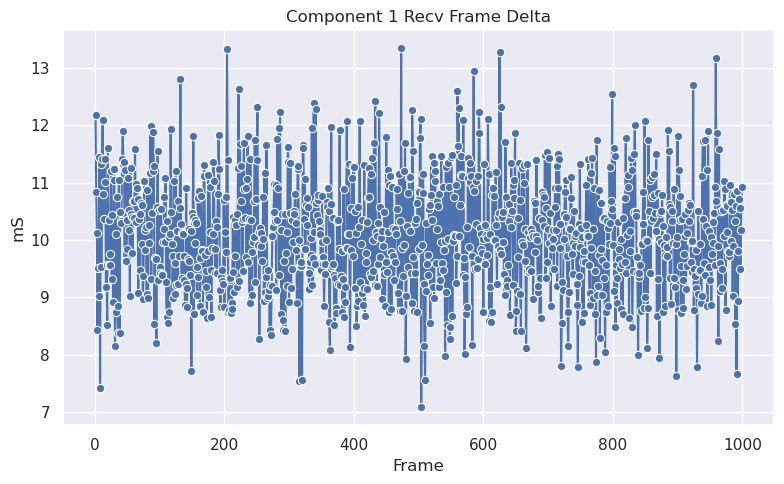

Component 2 Recv Delta Statistics:
count: 989.000
mean: 10.718
std: 5.021
skew: 1.378
kurtosis: 6.107


<Figure size 800x500 with 0 Axes>

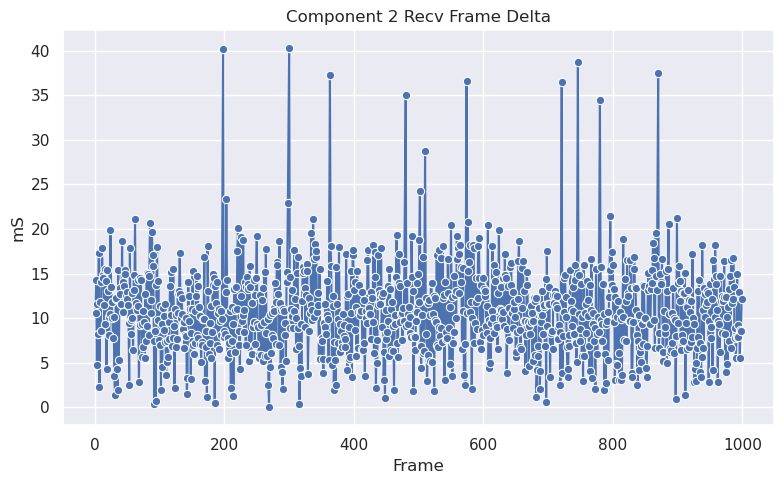

Component 3 Recv Delta Statistics:
count: 942.000
mean: 12.897
std: 8.823
skew: 1.749
kurtosis: 3.779


<Figure size 800x500 with 0 Axes>

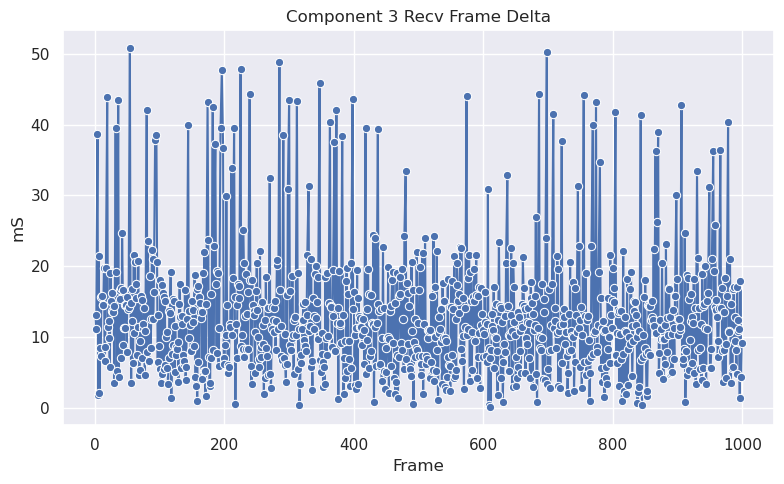

Component 4 Recv Delta Statistics:
count: 898.000
mean: 14.884
std: 11.091
skew: 1.415
kurtosis: 1.633


<Figure size 800x500 with 0 Axes>

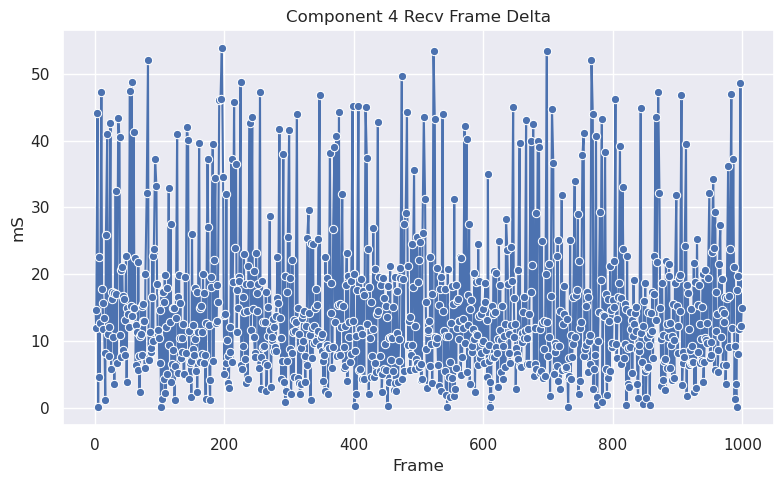

Component 5 Recv Delta Statistics:
count: 851.000
mean: 17.501
std: 13.379
skew: 1.152
kurtosis: 0.564


<Figure size 800x500 with 0 Axes>

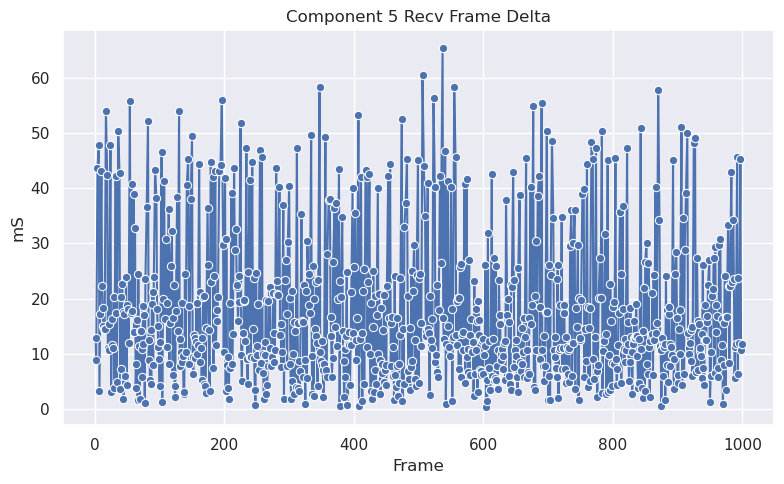

Component 6 Recv Delta Statistics:
count: 805.000
mean: 19.935
std: 14.919
skew: 0.875
kurtosis: -0.272


<Figure size 800x500 with 0 Axes>

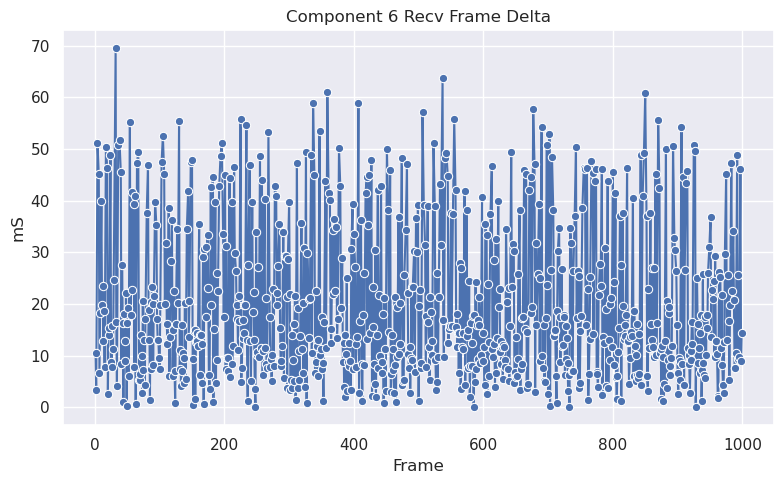

Component 7 Recv Delta Statistics:
count: 785.000
mean: 21.441
std: 15.795
skew: 0.802
kurtosis: -0.236


<Figure size 800x500 with 0 Axes>

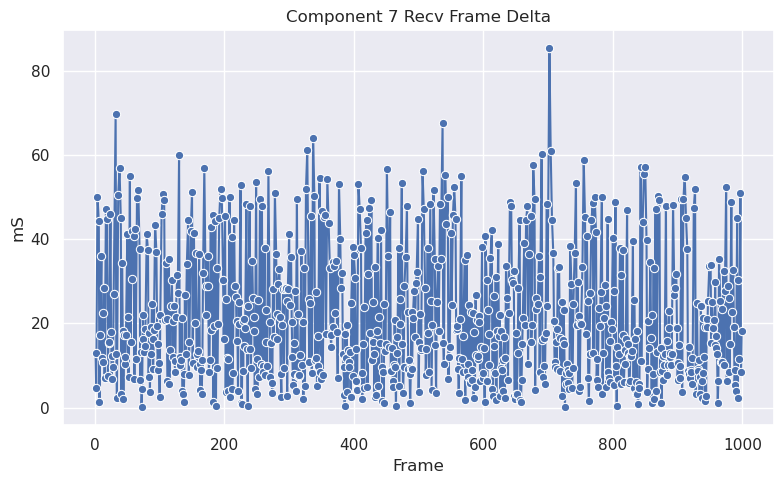

In [16]:
# for drop frames tracking - time delta between new recvd and last done (drop if negative)
# OK in your above data frame, i need to calculate all algebraic differences between the columns 'rcd_uS' - 'done_uS' such that the value of 'done_uS' 
# is obtained from the row previous to that of 'rcd_uS' unless the value of 'done_uS' in the same row as 'rcd_uS' is NaN in which case that row is skipped.  
# Under these conditions the next row will find the value of the previous rows value of 'done_uS' will be NaN and so the next more previous values 
# of 'done_uS' should be used to find the most recent non-NaN value for 'done_uS'.
# The first row for each component should be omitted from processing

for i in range(1, cmpnt_cnt + 1):

    plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # sns.lineplot(x=df.loc[df["component"] == i, "frm_nm"][1:], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers

    rcd_uS =  prcsdFrms_df.loc[prcsdFrms_df["component"] == i,  "rcd_uS"][1:].reset_index(drop=True)
    done_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "done_uS"][:-1].reset_index(drop=True)

    # print(i)
    # print(rcd)
    # print(done)

    delta_mS = u_m*(rcd_uS - done_uS)

    # Display statistics
    delta_stats_mS = compute_moments(delta_mS)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in delta_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # print(diff)
    # print(df.loc[df["component"] == i, "frm_nm"][1:])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"][1:].reset_index(drop=True), y=delta_mS , marker="o")       # line + markers
    plt.title(f"Component {i} Recv Frame Delta")
#    plt.xlabel("Minutes")
    plt.xlabel("Frame")
    plt.ylabel("mS")
    plt.tight_layout()
    plt.show()



Component 1 Recv Delta Statistics:
count: 999.000
mean: 15.139
std: 2.082
skew: 0.346
kurtosis: 0.285


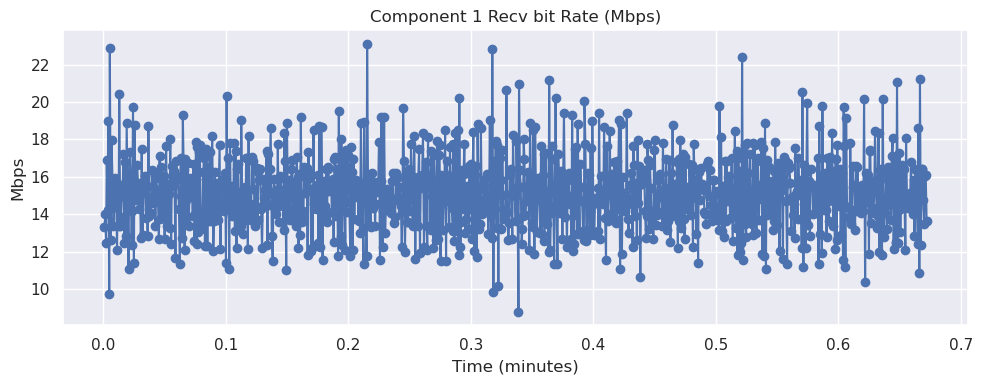

Component 2 Recv Delta Statistics:
count: 989.000
mean: 14.880
std: 2.067
skew: -0.036
kurtosis: 0.942


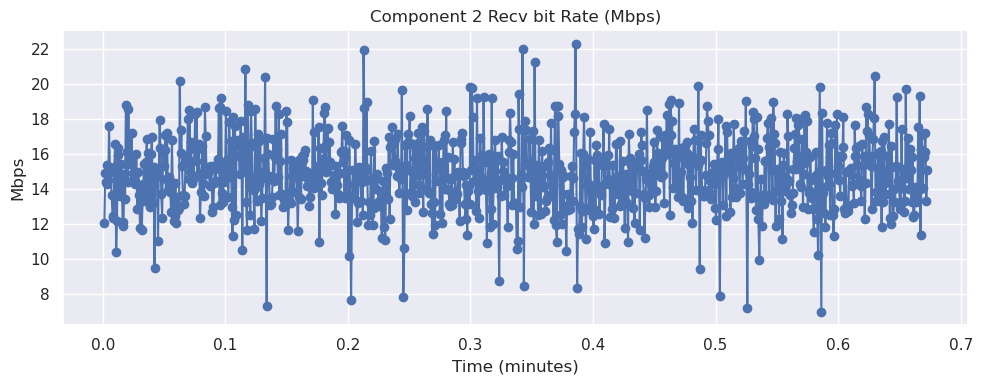

Component 3 Recv Delta Statistics:
count: 942.000
mean: 14.437
std: 2.793
skew: -0.091
kurtosis: 0.714


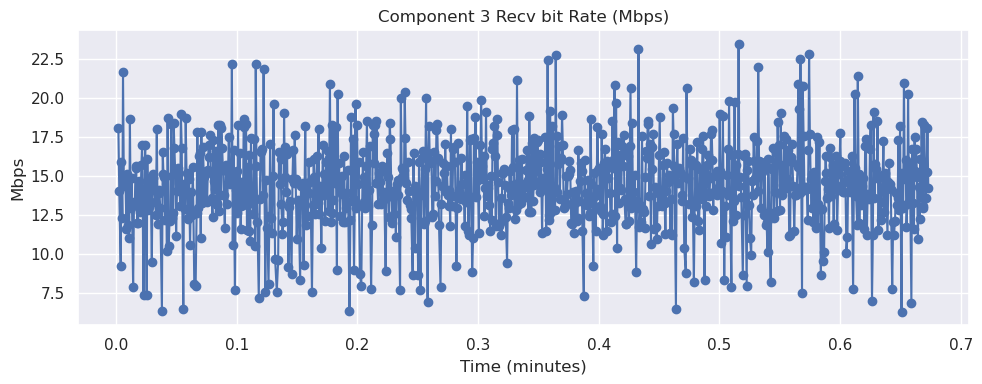

Component 4 Recv Delta Statistics:
count: 898.000
mean: 14.068
std: 3.202
skew: -0.176
kurtosis: -0.241


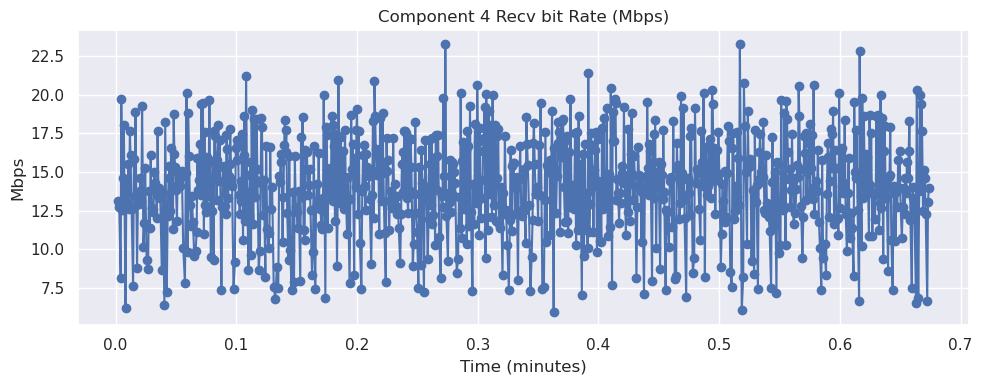

Component 5 Recv Delta Statistics:
count: 851.000
mean: 13.476
std: 3.467
skew: -0.050
kurtosis: -0.435


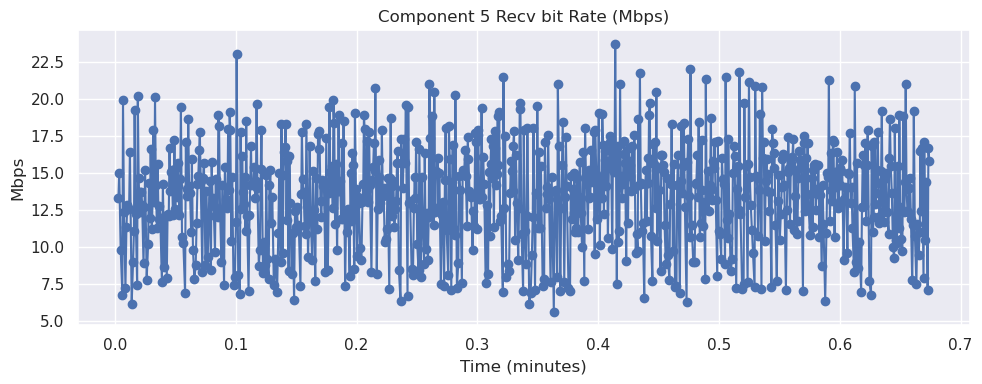

Component 6 Recv Delta Statistics:
count: 805.000
mean: 13.033
std: 3.736
skew: 0.187
kurtosis: -0.585


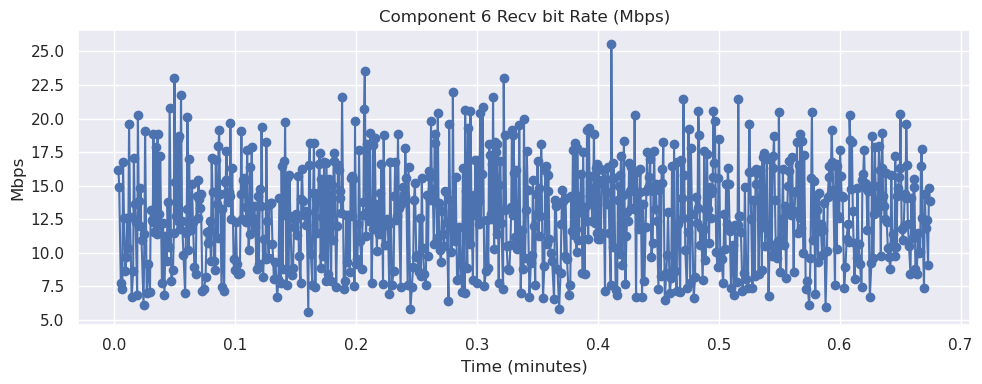

Component 7 Recv Delta Statistics:
count: 785.000
mean: 12.696
std: 3.813
skew: 0.204
kurtosis: -0.645


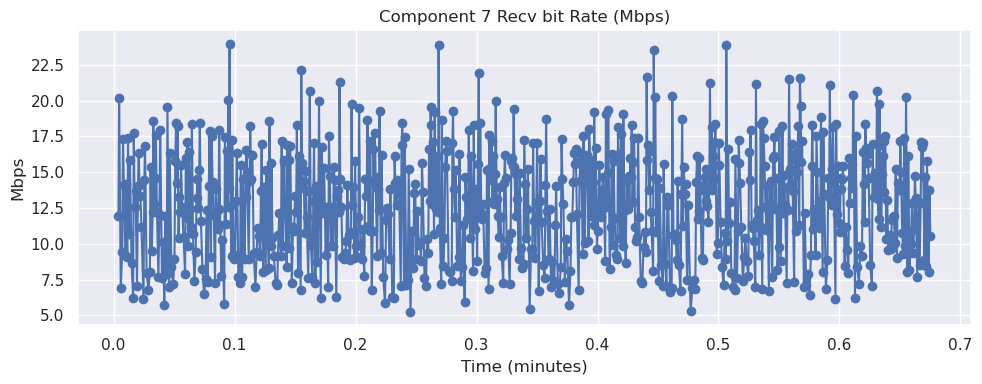

In [19]:
for i in range(1, cmpnt_cnt + 1):

    sim_tm_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][1:].reset_index(drop=True) - prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][:-1].reset_index(drop=True))
    szs_b = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {i} Recv bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 1000.000
mean: 30.273
std: 2.998
skew: 0.175
kurtosis: -0.031


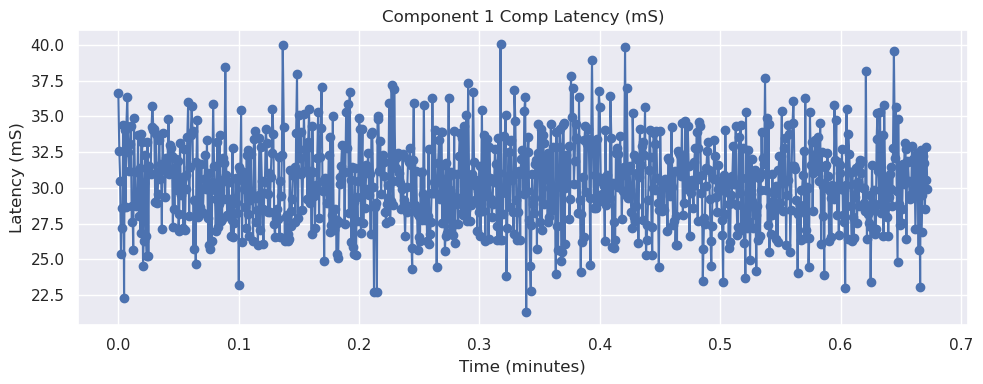

Component 2 Recv Delta Statistics:
count: 990.000
mean: 30.029
std: 3.054
skew: 0.229
kurtosis: 0.298


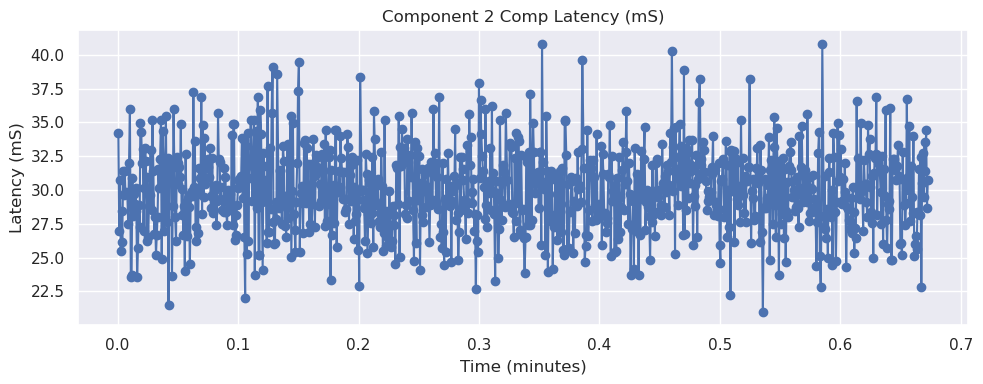

Component 3 Recv Delta Statistics:
count: 943.000
mean: 29.880
std: 3.029
skew: 0.235
kurtosis: -0.011


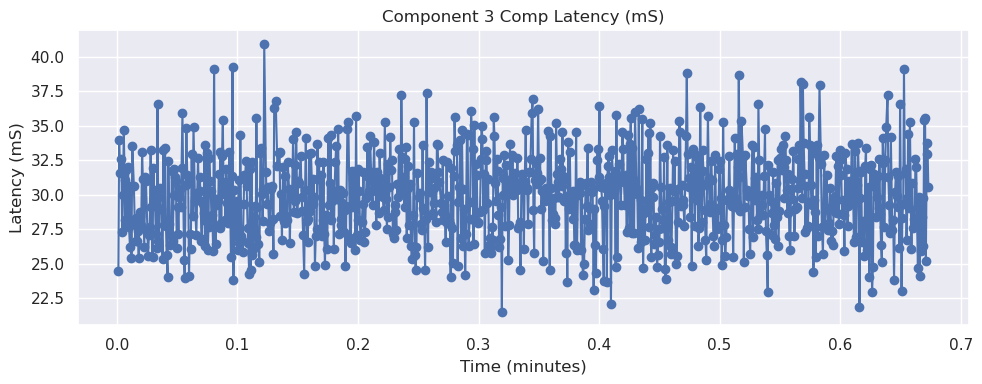

Component 4 Recv Delta Statistics:
count: 899.000
mean: 29.994
std: 3.000
skew: 0.232
kurtosis: 0.096


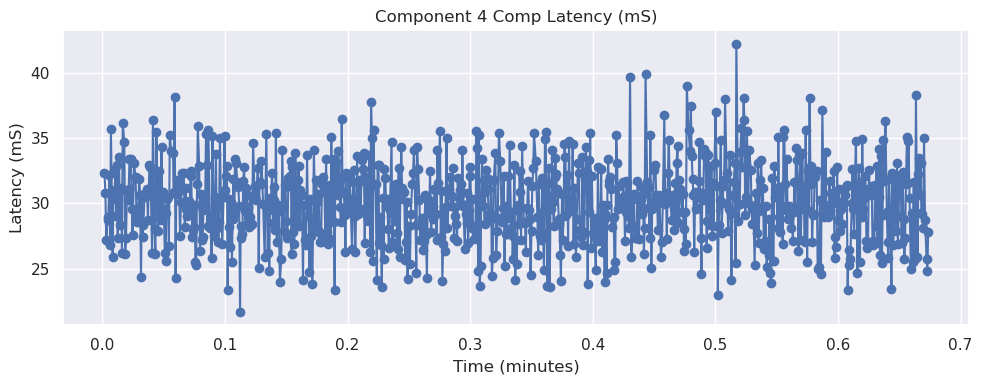

Component 5 Recv Delta Statistics:
count: 852.000
mean: 29.858
std: 3.034
skew: 0.188
kurtosis: 0.109


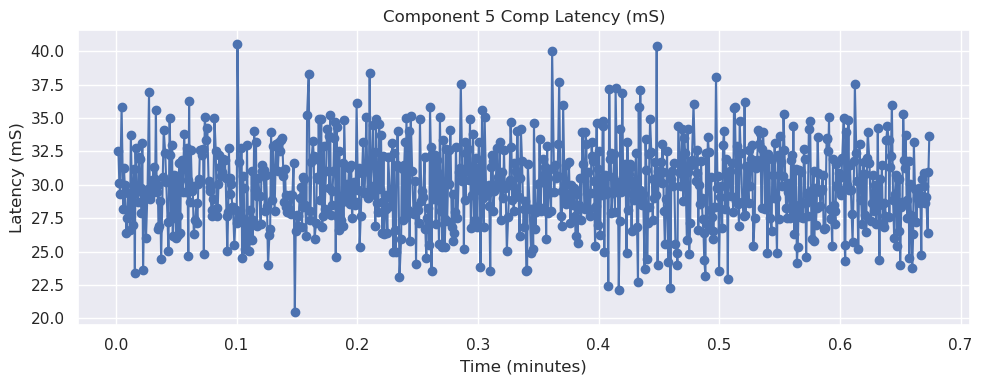

Component 6 Recv Delta Statistics:
count: 806.000
mean: 30.130
std: 3.102
skew: 0.294
kurtosis: 0.381


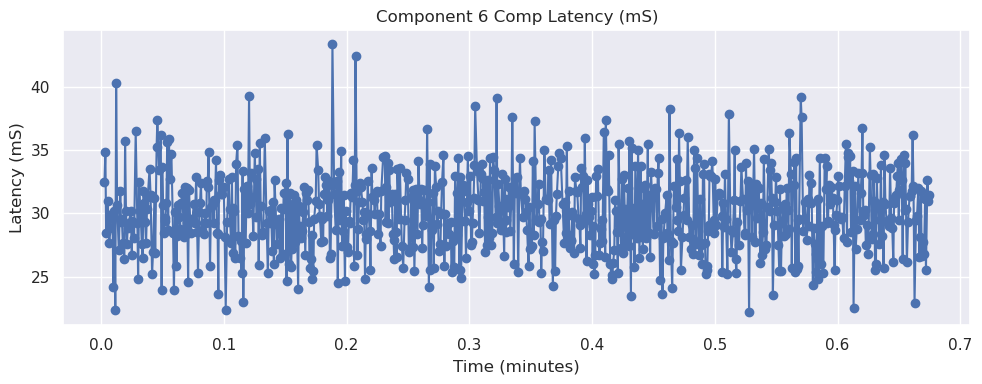

Component 7 Recv Delta Statistics:
count: 786.000
mean: 29.890
std: 3.012
skew: 0.086
kurtosis: 0.117


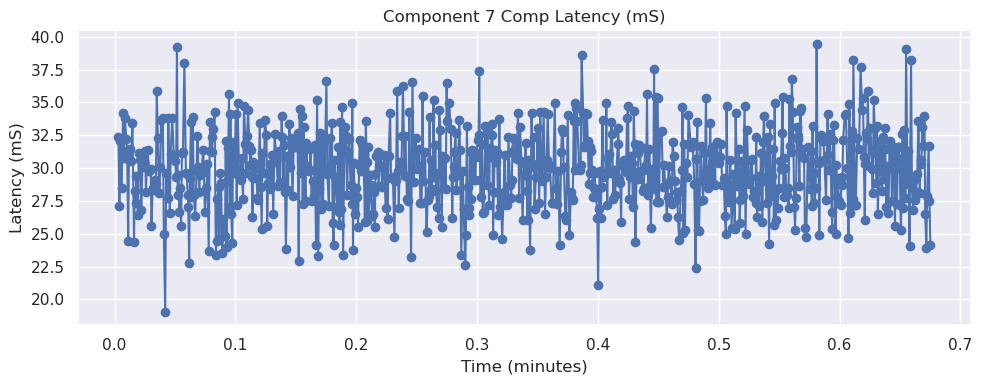

In [20]:
for i in range(1, cmpnt_cnt + 1):

    cmpLt_mS = u_m*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "cmp_ltnc_uS"]
    # Display statistics
    cmpLt_stats_mS = compute_moments(cmpLt_mS)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in cmpLt_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, cmpLt_mS, marker='o', linestyle='-')
    plt.title(f"Component {i} Comp Latency (mS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (mS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 1000.000
mean: 6.055
std: 0.600
skew: 0.175
kurtosis: -0.031


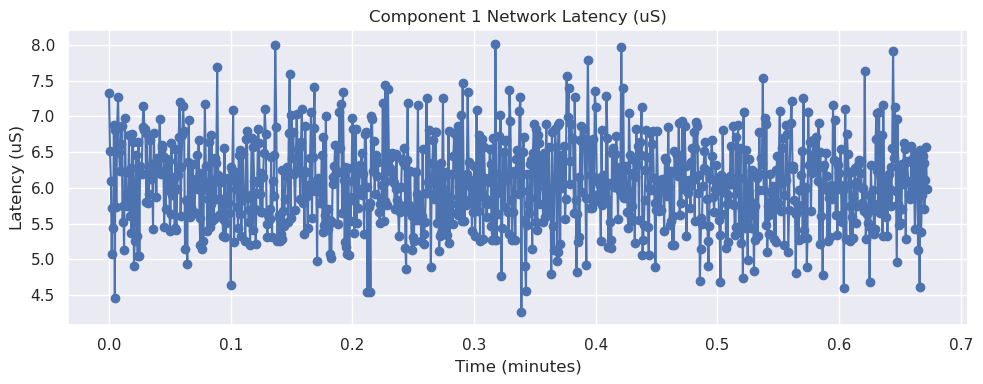

Component 2 Recv Delta Statistics:
count: 990.000
mean: 6.006
std: 0.611
skew: 0.229
kurtosis: 0.298


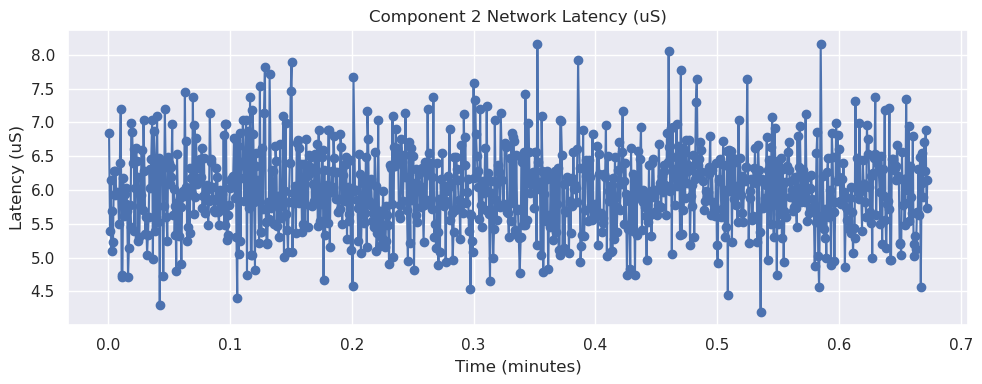

Component 3 Recv Delta Statistics:
count: 943.000
mean: 5.976
std: 0.606
skew: 0.235
kurtosis: -0.011


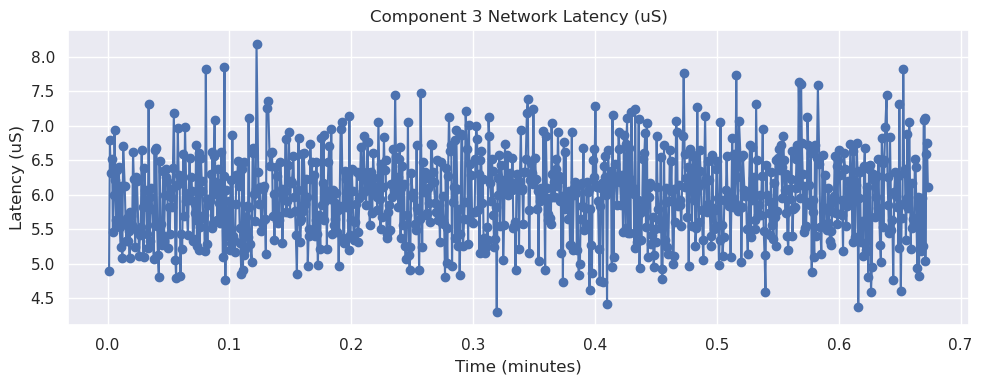

Component 4 Recv Delta Statistics:
count: 899.000
mean: 5.999
std: 0.600
skew: 0.232
kurtosis: 0.096


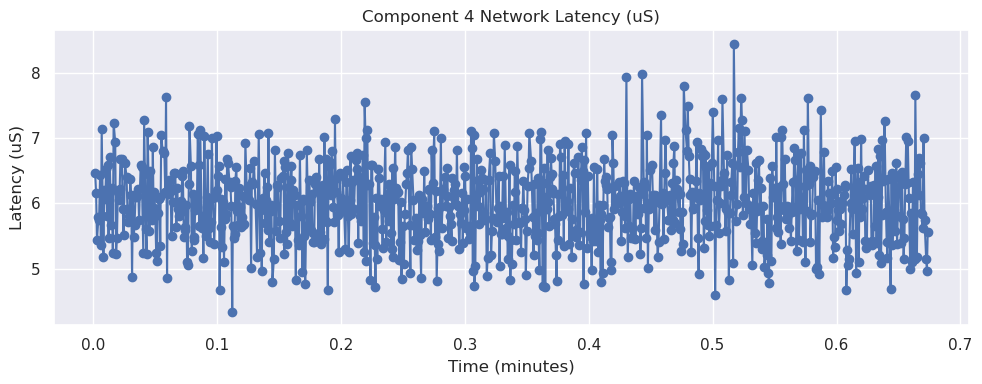

Component 5 Recv Delta Statistics:
count: 852.000
mean: 5.972
std: 0.607
skew: 0.188
kurtosis: 0.109


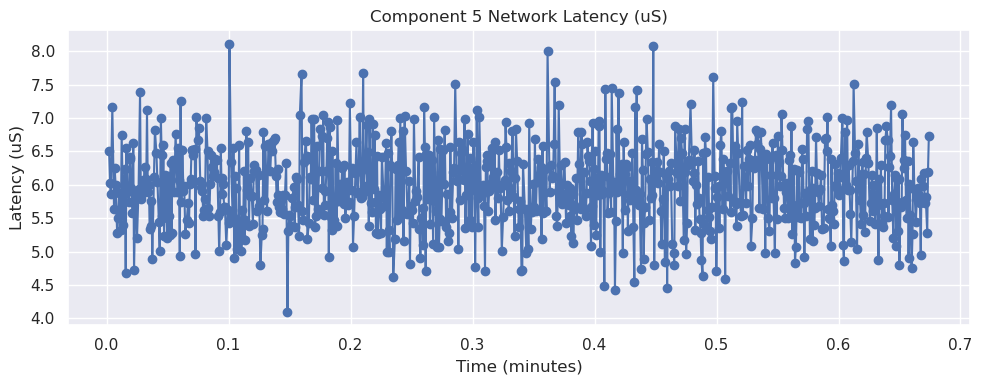

Component 6 Recv Delta Statistics:
count: 806.000
mean: 6.026
std: 0.620
skew: 0.294
kurtosis: 0.381


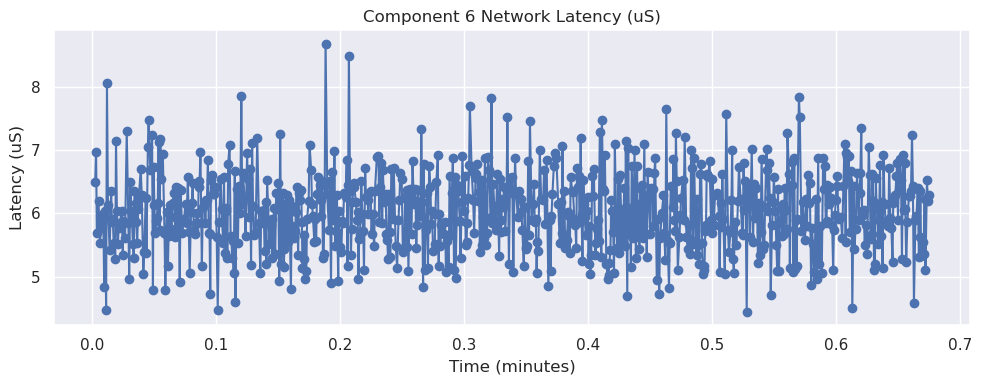

Component 7 Recv Delta Statistics:
count: 786.000
mean: 5.978
std: 0.602
skew: 0.086
kurtosis: 0.117


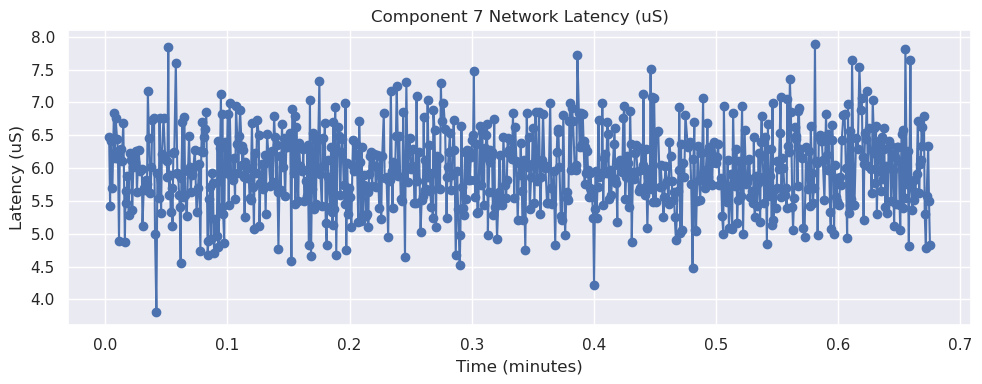

In [21]:
for i in range(1, cmpnt_cnt + 1):

    ntwrkLt_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "ntwrk_lt_uS"]
    # Display statistics
    ntwrkLt_stats_uS = compute_moments(ntwrkLt_uS)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in ntwrkLt_stats_uS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, ntwrkLt_uS, marker='o', linestyle='-')
    plt.title(f"Component {i} Network Latency (uS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (uS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

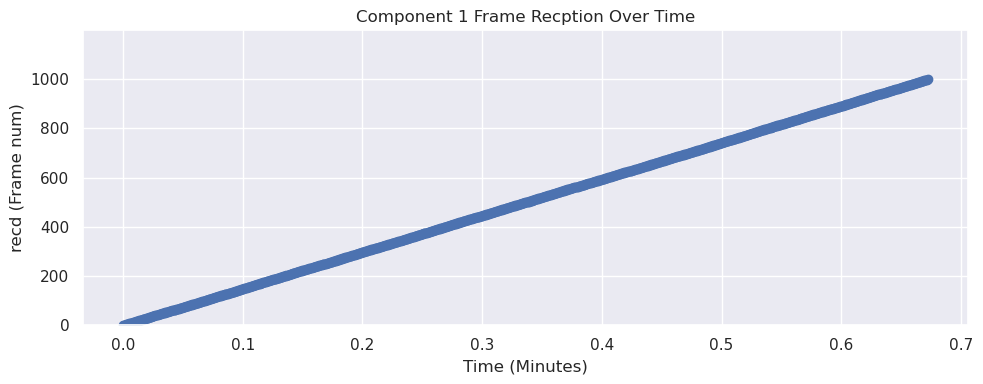

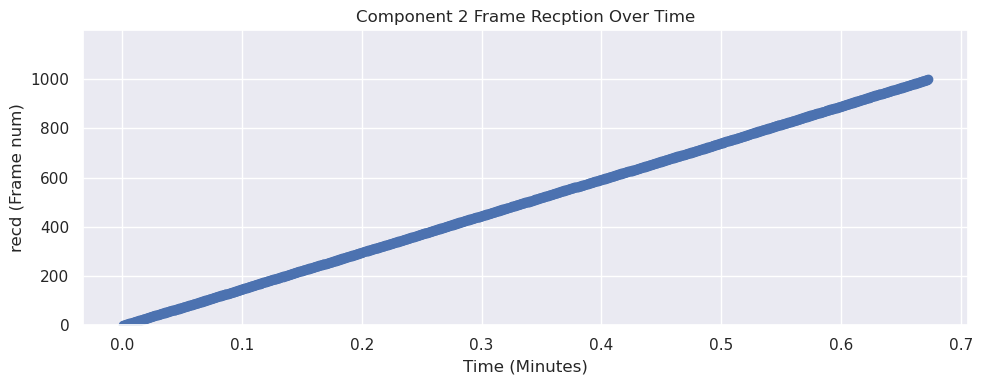

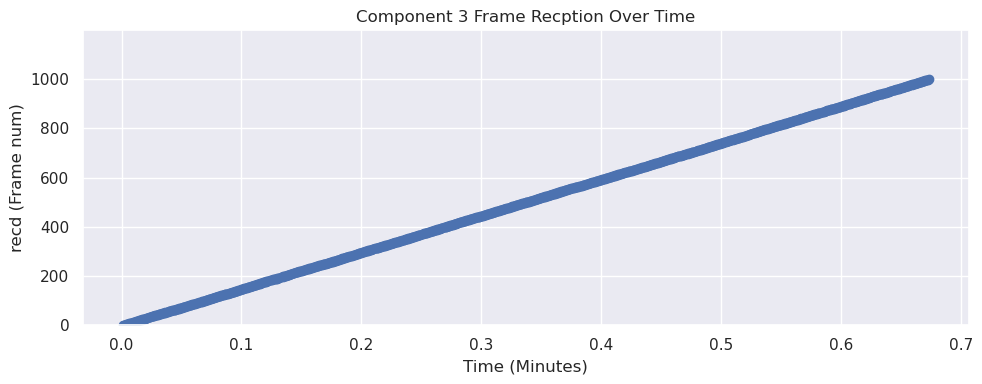

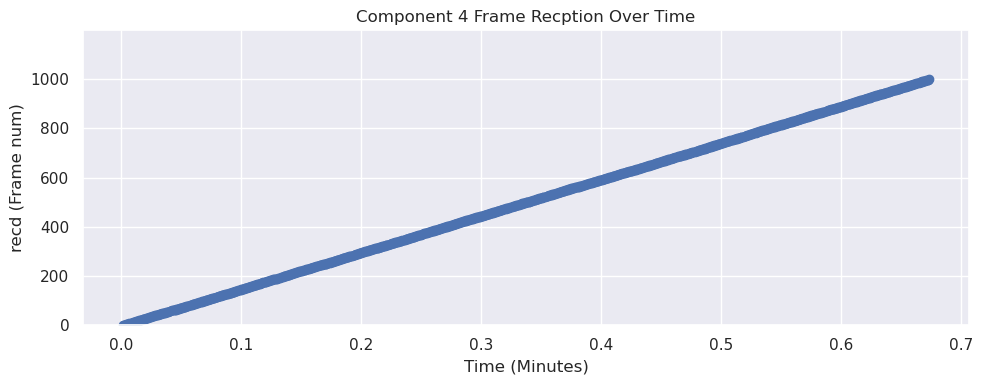

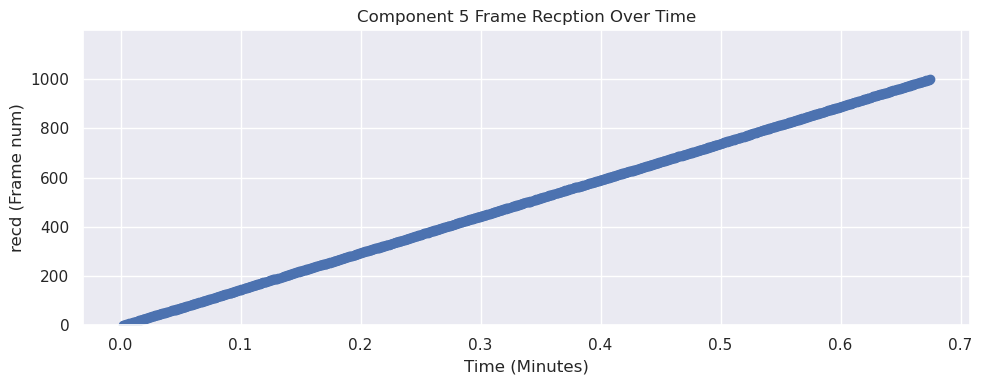

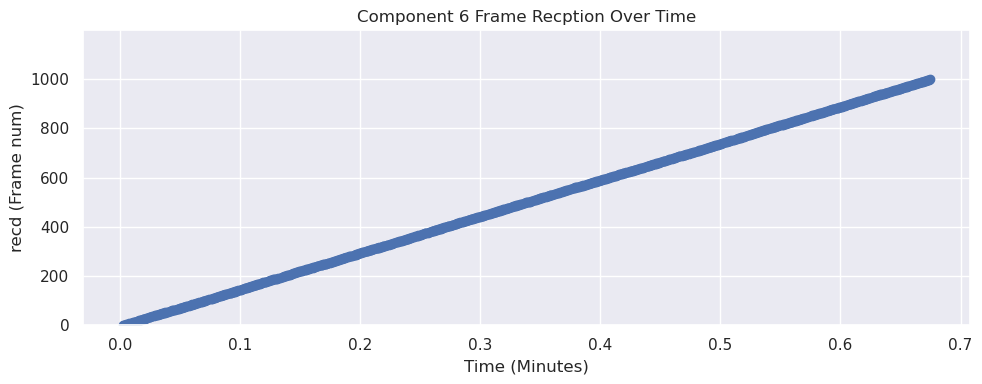

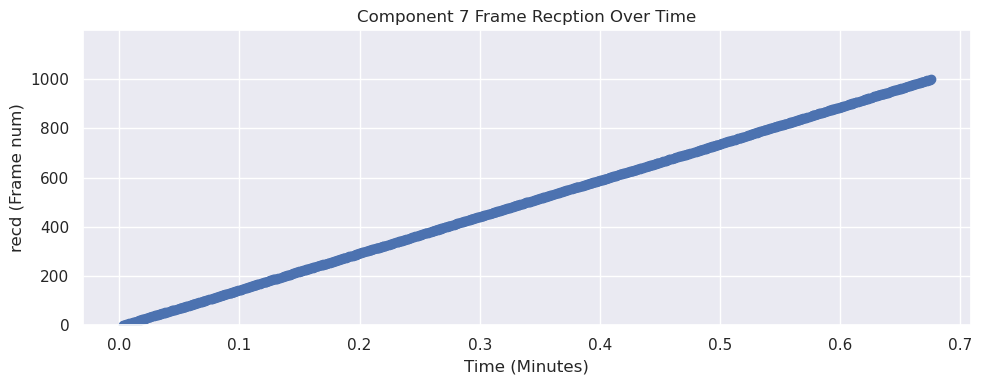

In [22]:
for i in range(1, cmpnt_cnt + 1):
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o', linestyle='-')
    plt.title(f"Component {i} Frame Recption Over Time")
    plt.xlabel('Time (Minutes)')
    plt.ylabel('recd (Frame num)')
    plt.ylim(0, max(prcsdFrms_df['frm_nm']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/scratch/slurm/53026789/.cache/tmp/ipykernel_1940569/673928686.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


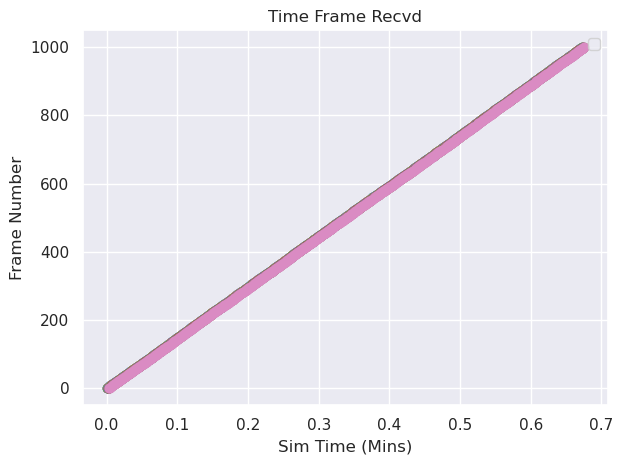

In [23]:
for i in range(1, cmpnt_cnt + 1):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Sim Time (Mins)')
plt.ylabel('Frame Number')
plt.title('Time Frame Recvd')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


/scratch/slurm/53026789/.cache/tmp/ipykernel_1940569/2619295548.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


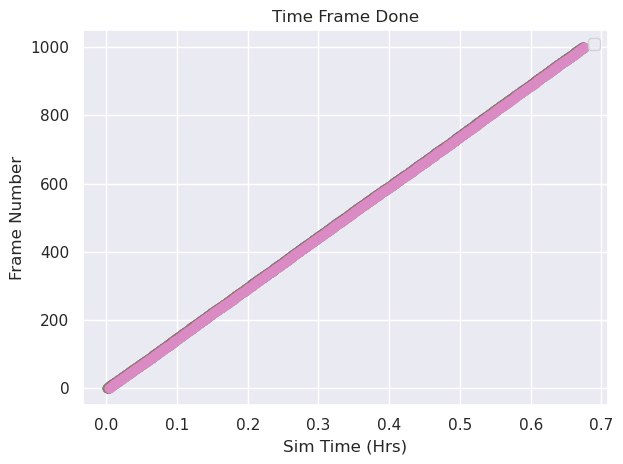

In [24]:
for i in range(1, cmpnt_cnt + 1):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "done_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Sim Time (Hrs)')
plt.ylabel('Frame Number')
plt.title('Time Frame Done')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
drpmsdFrms_df.head(5)

component         rcd_uS  frm_nm       frm_sz_b     lstDone_uS
0          3  183743.432528       3  624165.981997  185079.291652
1          5  314271.110787       5  583070.262061  321214.152198
2          4  448659.523969       9  542106.486163  448872.554278
3          5  773181.990902      16  536114.735053  778538.283298
4          3  797892.111818      18  568384.416006  799082.041241

In [26]:
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
for c in cmpnt_drp_nms:
    print(f"Number of drops for component {c}: {len(drp_sets_by_component[c])}")

Number of drops for component 2: 10
Number of drops for component 3: 47
Number of drops for component 4: 44
Number of drops for component 5: 47
Number of drops for component 6: 46
Number of drops for component 7: 20


In [27]:
drp_sets_by_component

component
2    {573, 197, 869, 745, 362, 299, 779, 720, 509, ...
3    {768, 897, 3, 773, 905, 269, 397, 143, 18, 284...
4    {645, 9, 522, 524, 141, 766, 655, 782, 912, 78...
5    {129, 257, 513, 5, 908, 16, 401, 914, 147, 532...
6    {642, 771, 261, 267, 277, 662, 30, 542, 670, 7...
7    {640, 517, 910, 529, 408, 152, 155, 667, 168, ...
Name: frm_nm, dtype: object

In [28]:
cmpnt_drp_nms

{np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}

In [29]:
prcsd_frm_sets_by_component = prcsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_frn_nms = set(prcsdFrms_df["component"].unique())
for c in cmpnt_frn_nms:
    print(f"Number of processed frames for component {c}: {len(prcsd_frm_sets_by_component[c])}")

Number of processed frames for component 1: 1000
Number of processed frames for component 2: 990
Number of processed frames for component 3: 943
Number of processed frames for component 4: 899
Number of processed frames for component 5: 852
Number of processed frames for component 6: 806
Number of processed frames for component 7: 786


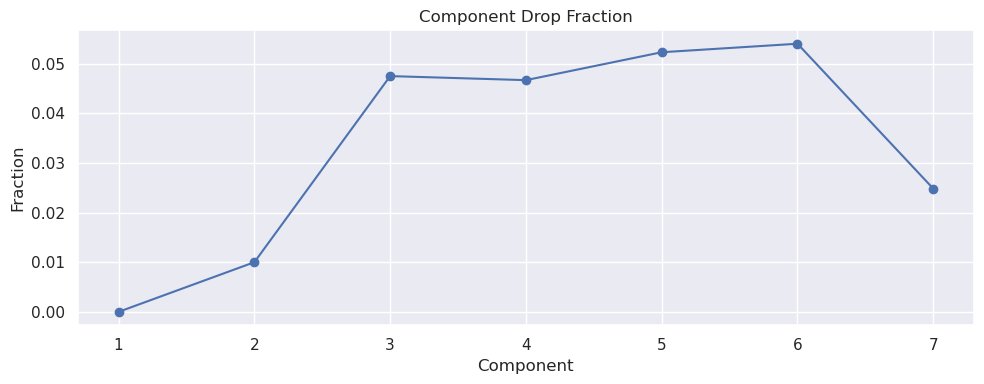

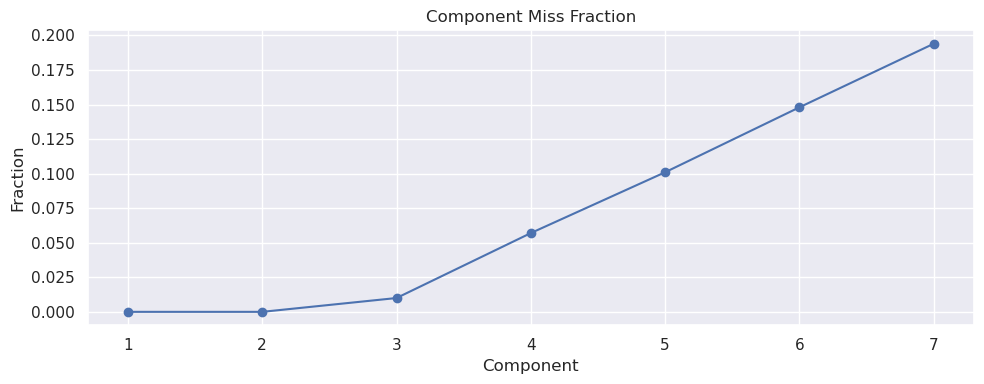

In [30]:
drpdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "drp_frctn":   pd.Series(dtype=int)
})

cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
#dataframe record for components with no drops
for c in set(range(1,cmpnt_cnt+1)) - cmpnt_drp_nms: #the set of compnents with no drops
    row = (c,0)
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)
    
#dataframe record for components with drops
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
for c in cmpnt_drp_nms:
    row = (c,len(drp_sets_by_component[c])/(len(drp_sets_by_component[c]) + len(prcsd_frm_sets_by_component[c])))
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)


# drpdFrmsFrctn_df

# Plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

x = drpdFrmsFrctn_df['component'].astype(int)
y = drpdFrmsFrctn_df['drp_frctn']
max_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Drop Fraction")
ax.set_xlabel("Component")
ax.set_ylabel("Fraction")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()

#Frames that components missed because they were never received
msdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "msd_frctn": pd.Series(dtype=int)
})

#Compnents miss frames when upstream senders do not send
#Upstrean components do not send frames they miss or drop
#The effect is cummulative for downstream components

#For each component, This equates to the number of sender frames - (number processd + the number droped (since they were not missed))

for c in range(1,cmpnt_cnt+1):
    # print(f"drpdFrmsFrctn_df for component {c}: {drpdFrmsFrctn_df.loc[drpdFrmsFrctn_df["component"] == (c-1), "drp_frctn"]}")
    # row = (c,1-(len(prcsd_frm_sets_by_component[c]) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c, "frm_nm"])))/len(all_frm_set))
    row = (c,1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == c, "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c, "frm_nm"])))/len(all_frm_set))
    msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

x = msdFrmsFrctn_df['component'].astype(int)
y = msdFrmsFrctn_df['msd_frctn']
ax_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Miss Fraction")
ax.set_xlabel("Component")
ax.set_ylabel("Fraction")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()


In [31]:
# for c in range(1,cmpnt_cnt+1):
#     print(len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c, "frm_nm"])))